# Importing libraries and Loading data

In [1]:
import os
import torch
import numpy as np
from PIL import Image
from pathlib import Path
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# from timm import create_model
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.models import vgg16, vgg19
from torchvision.datasets import ImageFolder
from transformers import CLIPProcessor, CLIPModel

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    # transforms.Resize((224, 224)),  # works for all models
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.2435, 0.2616))  # CIFAR-10 mean and std
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

print(f'Total number of images in CIFAR 10 test_loader: {len(test_dataset)}')

cifar10_classes = [
    'airplane', 'automobile',  'ship', 'truck'
    'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
]

100%|██████████| 170498071/170498071 [00:03<00:00, 48572088.66it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Total number of images in CIFAR 10 test_loader: 10000


# Helper functions and visualizing utils

torch.Size([3, 32, 32])


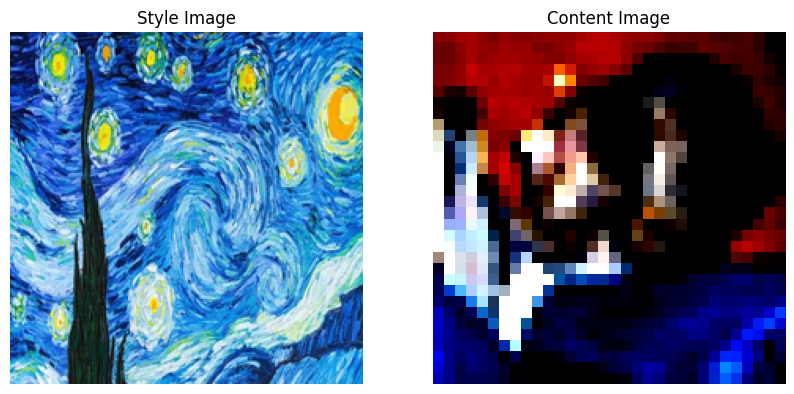

In [3]:
def load_image(image_input):
    if not isinstance(image_input, torch.Tensor):
        image = Image.open(image_input)
        image = image.resize((224, 224), Image.LANCZOS)
        image_array = np.array(image)
    else:  #tensors from dataset are already resized
      image = image_input
      if image_input.dim() == 4:  #extra batch dimension
        image_array = image_input.squeeze(0).cpu().numpy()
      else:
        image_array = image_input.cpu().numpy()


    if isinstance(image_input, torch.Tensor):  #transpose the tensor from dataset from viewing in plot if required
      image_array = np.transpose(image_array,(1, 2, 0))  # Convert CHW to HWC

    return image_array

# Load and preprocess the content and style images
style_pic_path = '/kaggle/input/stary-night2/starry_night.jpg'
img, _ = test_dataset[0]
print(img.shape)
content_img = load_image(img)
style_img = load_image(style_pic_path)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(style_img)
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(content_img)
plt.title('Content Image')
plt.axis('off')
plt.show()

In [4]:
#function to extract features from the VGG mdoel
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  # Content layer
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

# function to calculate the Gram matrix:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# function to visualise images with diff styles
def show_images_diff_styles(style_img, content_img, styled_content_img):

  if isinstance(content_img, torch.Tensor):
    content_img = content_img.cpu().numpy()
    content_img = np.transpose(content_img,(1, 2, 0))

  styled_img = load_image(styled_content_img)

  plt.figure(figsize=(12, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(style_img)
  plt.title('Style Image')
  plt.axis('off')

  plt.subplot(1, 3, 2)
  plt.imshow(content_img)
  plt.title('Content Image')
  plt.axis('off')

  plt.subplot(1, 3, 3)
  plt.imshow(styled_img)
  plt.title('Styled Content Image')
  plt.axis('off')
  plt.show()

import torchvision.transforms as T


import os
import torch

def savedata(img_tensor, img_label, i, save_path):
    # Ensure the directory exists
    os.makedirs(os.path.join(save_path, 'tensors'), exist_ok=True)
    
    # Save the tensor to a file
    tensor_path = os.path.join(save_path, 'tensors', f'img_{i:04d}.pt')
    torch.save(img_tensor, tensor_path)
    
    # Save the label in the labels.txt file
    labels_file_path = os.path.join(save_path, 'labels.txt')
    with open(labels_file_path, 'a') as f:
        f.write(f'img_{i:04d}.pt {img_label}\n')  # Save label with .pt extension


In [5]:
# del vgg19
# torch.cuda.empty_cache()
vgg19 = vgg19(pretrained=True).features
vgg19 = vgg19.to(device)
vgg19.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 210MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# Saving as png

In [6]:
import os
from PIL import Image

def savedata_png(tensor, index, save_path):
    """
    Save a tensor as a PNG image.
    
    Args:
        tensor (Tensor): PyTorch tensor of shape (C, H, W), range [0, 1].
        index (int): File index for naming the image.
        save_path (str): Directory path to save the image.
    """
    # Ensure the save directory exists
    os.makedirs(save_path, exist_ok=True)

    # Convert tensor to (H, W, C) and scale to [0, 255]
    tensor = tensor.cpu().clamp(0, 1)  # Ensure values are in [0, 1]
    tensor = (tensor * 255).byte().permute(1, 2, 0)  # Scale to [0, 255] and convert to (H, W, C)

    # Convert tensor to PIL Image
    img = Image.fromarray(tensor.numpy())

    # Save the image as PNG
    image_filename = f"img_{index:04d}.png"
    image_path = os.path.join(save_path, image_filename)
    img.save(image_path)


# The Actual Style Transfer Part

In [7]:
def style_transfer(content_img, style_img, num_steps=85, style_weight=0.2, content_weight=0.8):

    if not isinstance(content_img, torch.Tensor):
        content_img = torch.from_numpy(content_img).float().permute(2, 0, 1).unsqueeze(0)
    if not isinstance(style_img, torch.Tensor):
        style_img = torch.from_numpy(style_img).float().permute(2, 0, 1).unsqueeze(0)
        style_img /=255

    target = content_img.to(device).clone().detach().requires_grad_(True)
    content_img = content_img.to(device)
    style_img = style_img.to(device)


    optimizer = torch.optim.Adam([target], lr=0.2)
    content_features = get_features(content_img, vgg19)
    style_features = get_features(style_img, vgg19)

    style_weights = {'conv1_1': 1.0,
                     'conv2_1': 0.8,
                     'conv3_1': 0.5,
                     'conv4_1': 0.3,
                     'conv5_1': 0.1}

    for i in range(1, num_steps+1):
        target_features = get_features(target, vgg19)

        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = gram_matrix(style_features[layer])
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward(retain_graph=True)
        optimizer.step()


    return target.detach()



def apply_style_transfer(shortened_imgs, shortened_labels, style_image, save_path):
    """
    Apply style transfer to a partition of images and save the results as PNG images.
    Write a single labels.txt file for the entire partition.
    
    Args:
        shortened_imgs (list): List of image tensors in the partition.
        shortened_labels (list): List of labels corresponding to the images.
        style_image (Tensor): The style image tensor.
        save_path (str): Directory path to save styled images and labels.
    """
    styled_images = []
    labels_list = []

    # Create path for labels.txt
    label_file = os.path.join(save_path, "labels.txt")

    for i, image in enumerate(shortened_imgs):
        label = shortened_labels[i]

        # Resize the image to 224x224
        resizetransform = transforms.Compose([
            transforms.Resize((224, 224)),  # Resize to 224x224
        ])
        image = resizetransform(image)

        # Apply style transfer
        styled_image = style_transfer(image.unsqueeze(0), style_image)

        # Add the styled image to the list
        styled_images.append(styled_image)

        # Append the filename and label to the list
        labels_list.append((f"img_{i:04d}.png", label))

        # Save the styled image
        savedata_png(styled_image.squeeze(0), i, save_path)

    # Write all labels to a single labels.txt file
    with open(label_file, "w") as f:
        for filename, label in labels_list:
            f.write(f"{filename} {label}\n")

    # Return concatenated tensors for styled images and labels
    return torch.cat(styled_images), torch.tensor([lbl for _, lbl in labels_list], dtype=torch.int64)


# Testing on a small subset

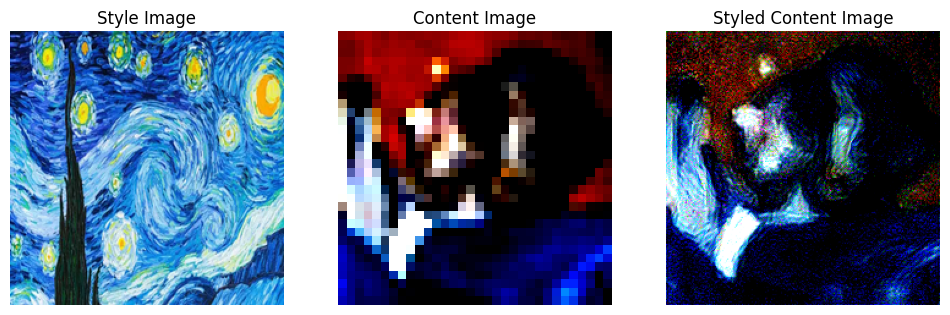

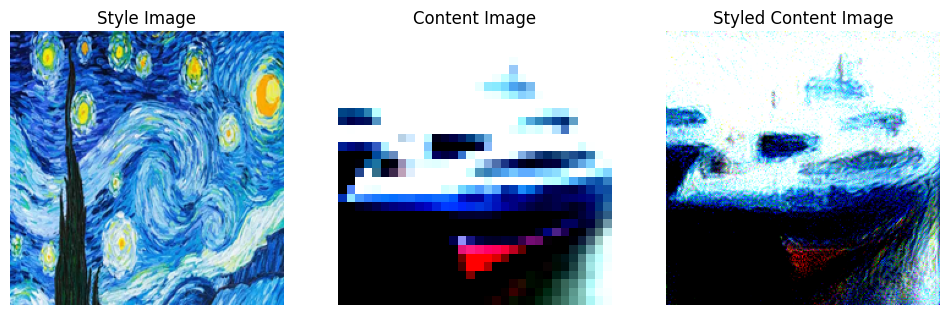

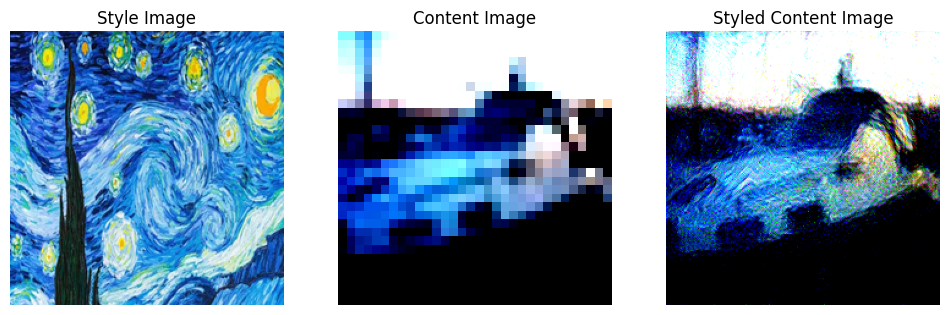

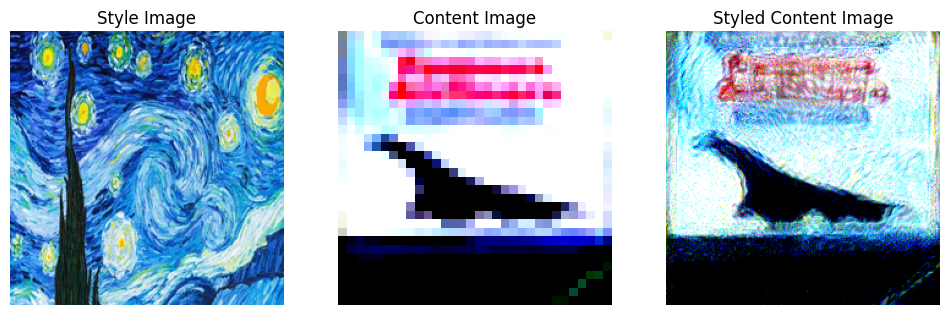

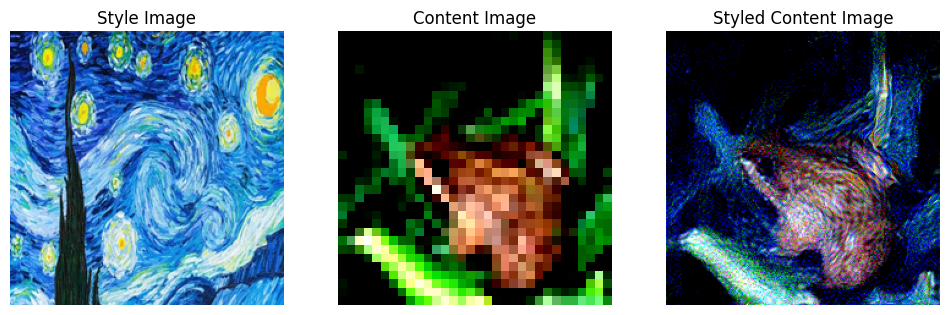

In [8]:
def apply_style_transfer_subset(image_subset, label_subset, style_image, start_index):
    styled_images = []
    labels_list = []

    save_path = '/kaggle/working/sampleonlypng'  # Path where images will be saved

    for i, (image, label) in enumerate(zip(image_subset, label_subset)):
        # Resize the image to 224x224
        resizetransform = transforms.Compose([
            transforms.Resize((224, 224)),
        ])
        image = resizetransform(image)

        # Apply style transfer
        styled_image = style_transfer(image.unsqueeze(0), style_image)
        styled_images.append(styled_image)
        labels_list.append(label)

        # Save styled image as PNG and label
        file_index = start_index + i
        savedata_png(styled_image.squeeze(0), file_index, save_path)

    return styled_images, labels_list


# Small sample indices (first 5 images)
small_indices = [0, 1, 2, 3, 4]
small_imgs = [test_dataset[i][0] for i in small_indices]
small_labels = [test_dataset[i][1] for i in small_indices]

# Load the style image
style_img = load_image(style_pic_path)

# Apply style transfer to the subset and save as PNG
styled_images, styled_labels = apply_style_transfer_subset(small_imgs, small_labels, style_img, start_index=0)

# Verify the result by visualizing the styled images
for i, img_tensor in enumerate(styled_images):
    show_images_diff_styles(style_img, small_imgs[i], img_tensor)




# Functions for Saving tensors as png and Displaying png as tensor


In [9]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def load_png_as_tensor(image_path):
    """
    Load a saved PNG image and convert it to a PyTorch tensor.
    Args:
        image_path (str): Path to the PNG image.
    Returns:
        Tensor: A PyTorch tensor of shape (C, H, W), range [0, 1].
    """
    # Load the image using PIL
    img = Image.open(image_path).convert("RGB")

    # Convert the image to a PyTorch tensor (C, H, W) and normalize to [0, 1]
    to_tensor = transforms.ToTensor()
    tensor = to_tensor(img)

    return tensor

def display_tensor_as_image(tensor):
    """
    Display a PyTorch tensor as an image.
    Args:
        tensor (Tensor): A PyTorch tensor of shape (C, H, W), range [0, 1].
    """
    # Convert tensor (C, H, W) to (H, W, C) for displaying
    img = tensor.permute(1, 2, 0).numpy()

    # Display the image
    plt.imshow(img)
    plt.axis("off")
    plt.show()



# Creating Partitions

In [10]:
# Partitioning the CIFAR-10 test dataset into chunks of 2500 images
partition_size = 1000
num_partitions = len(test_dataset) // partition_size
remaining_images = len(test_dataset) % partition_size


# Creating directories to save styled datasets
save_path = '/kaggle/working/partition10'
os.makedirs(save_path, exist_ok=True)

# Applying Style Transfer to Partition 1

In [11]:
partition = 9  # Change this to manually select the partition you want to run
start_idx = partition * partition_size
end_idx = start_idx + partition_size
# end_idx = 3
partition_imgs = [test_dataset[i][0] for i in range(start_idx, end_idx)]
partition_labels = [test_dataset[i][1] for i in range(start_idx, end_idx)]

# Apply style transfer to the images in this partition
style_img = load_image(style_pic_path)
styled_images, styled_labels = apply_style_transfer(partition_imgs, partition_labels, style_img,save_path)


# Loading a png, converting it to tensor and then displaying it

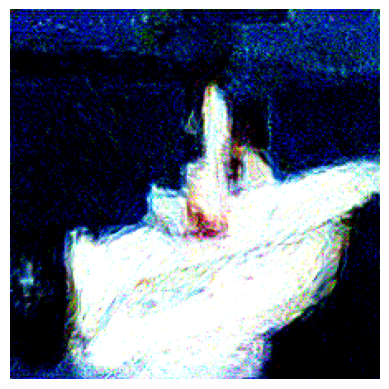

In [12]:
# Example usage
# Path to a saved image (update this to match your saved image path)
image_path = '/kaggle/working/partition10/img_0000.png'

# Load the image as a tensor
tensor = load_png_as_tensor(image_path)

# Display the tensor as an image
display_tensor_as_image(tensor)

# convert to zip

In [13]:
!zip -r partition10.zip partition10/


  adding: partition10/ (stored 0%)
  adding: partition10/img_0047.png (deflated 0%)
  adding: partition10/img_0955.png (deflated 0%)
  adding: partition10/img_0712.png (deflated 0%)
  adding: partition10/img_0894.png (deflated 0%)
  adding: partition10/img_0250.png (deflated 0%)
  adding: partition10/img_0403.png (deflated 0%)
  adding: partition10/img_0853.png (deflated 0%)
  adding: partition10/img_0435.png (deflated 0%)
  adding: partition10/img_0764.png (deflated 0%)
  adding: partition10/img_0497.png (deflated 0%)
  adding: partition10/img_0279.png (deflated 0%)
  adding: partition10/img_0231.png (deflated 0%)
  adding: partition10/img_0501.png (deflated 0%)
  adding: partition10/img_0823.png (deflated 0%)
  adding: partition10/img_0396.png (deflated 0%)
  adding: partition10/img_0708.png (deflated 0%)
  adding: partition10/img_0589.png (deflated 0%)
  adding: partition10/img_0278.png (deflated 0%)
  adding: partition10/img_0243.png (deflated 0%)
  adding: partition10/img_0578.png

In [14]:
from IPython.display import FileLink

# Provide a download link for the zip file
FileLink('partition10.zip')


/kaggle/working/partition10.zip

In [15]:
# img, _ = test_dataset[0]
# content_img = load_image(img)
# style_img = load_image(style_pic_path)
# styled_content_img = style_transfer(content_img, style_img)
# show_images_diff_styles(style_img, content_img, styled_content_img)

# # print(content_img.shape, styled_content_img.shape)